In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
from fastai.callback.hook import *

In [ ]:
# Untar data
path = untar_data(URLs.PETS)

In [ ]:
# List the contents of the dataset directory
print(path.ls())


[Path('/root/.fastai/data/oxford-iiit-pet/annotations'), Path('/root/.fastai/data/oxford-iiit-pet/images')]


In [ ]:
# Define the path to the dataset
path = Path('/root/.fastai/data/oxford-iiit-pet/images')

Path.BASE_PATH = '/root/.fastai/data/oxford-iiit-pet/image'

In [ ]:
# List images in path
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_165.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_54.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_31.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_59.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_119.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_196.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_121.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_229.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_218.jpg')...]

In [ ]:
# Get all image files from the dataset
image_files = get_image_files(path)

# Function to calculate image sizes
def calculate_image_size_stats(image_files):
    widths, heights = [], []
    for img_path in image_files:
        img = PILImage.create(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

    return widths, heights

# Calculate the image sizes
widths, heights = calculate_image_size_stats(image_files)

In [ ]:
# Calculate statistics on widths and heights using NumPy
width_stats = {
    "min_width": np.min(widths),
    "max_width": np.max(widths),
    "mean_width": np.mean(widths),
    "median_width": np.median(widths),
    "std_width": np.std(widths)
}

height_stats = {
    "min_height": np.min(heights),
    "max_height": np.max(heights),
    "mean_height": np.mean(heights),
    "median_height": np.median(heights),
    "std_height": np.std(heights)
}

In [ ]:
# Print the statistics for image widths and heights
print("Width Statistics:", width_stats)
print("Height Statistics:", height_stats)

Width Statistics: {'min_width': 114, 'max_width': 3264, 'mean_width': 436.7451962110961, 'median_width': 500.0, 'std_width': 115.86945970392384}
Height Statistics: {'min_height': 103, 'max_height': 2606, 'mean_height': 390.9136671177267, 'median_height': 375.0, 'std_height': 109.5789091791415}


In [ ]:
 # Define function that returns DataLoader with a batch size of 512
 # Images are resized to height of 375 and width of 512 (medians in the dataset)
def get_dls(bs=512, img_size=(375, 500)):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImage), CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2), # Split the data into training and validation sets, reserving 20% for validation
        get_y=parent_label,
        item_tfms=Resize(img_size, method='pad', pad_mode='zeros'),  # Apply transformation to resize images to a uniform size, padding with zeros if necessary
        batch_tfms=Normalize.from_stats(*imagenet_stats)  # Use normalization
    ).dataloaders(path, bs=bs)


In [ ]:
# Create the DataLoader object by calling the get_dls function with default parameters (batch size of 512 and image size 375x500)
dls = get_dls()

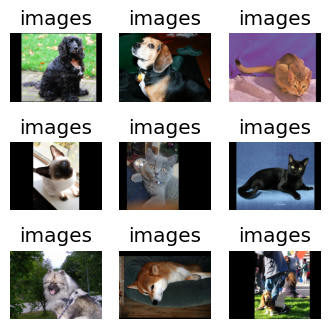

In [ ]:
# Show 9 images as a test
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
# Define convolution function
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
# CNN model.  First layer has 3 inputs channels as RGB images
def simple_cnn():
    return sequential(
        conv(3 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [ ]:
# use 1cycle training in fastai by calling fit_one_cycle
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
# Run model for one epoch
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,4.543686,1.815495,0.809878,09:41


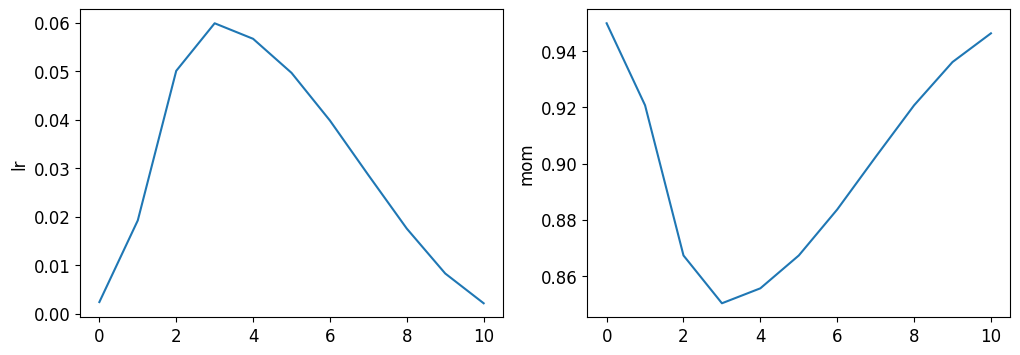

In [ ]:
learn.recorder.plot_sched()

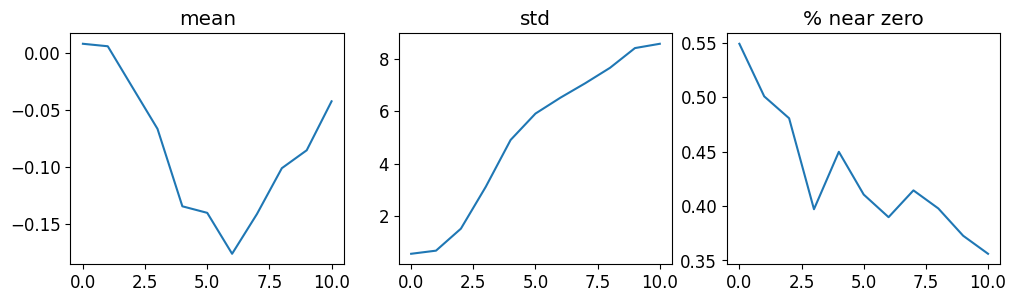

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

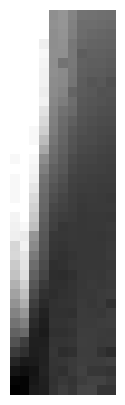

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
# Run model for 5 epochs
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.354481,20.689878,0.076455,09:23
1,1.507381,0.003800,0.997970,09:14
2,0.890208,0.001660,0.999323,09:14
3,0.589031,0.000899,0.999323,09:10
4,0.414104,0.000291,1.000000,09:14
